In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # comment this out if higher resolution is not needed

In [2]:
# Remember to always check that these files look the way you want before you run this! see data-di-with-gay to regenerate

joined_tox = pd.read_csv('joined_tox.csv')
train_comments = pd.read_csv('train_comments.csv')
test_comments = pd.read_csv('test_comments.csv')
madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']

In [3]:
# Generates perturbations
# Basically, creates num_perturbations number of arrays. 
# Each array is the length of the train_comments
# Each item in the array is 0/1 and is PROBABILITY_FLIP flipped from the true value of binary toxicity 

PROBABILITY_FLIP = 0.5
def generate_perturbation_on_training(train_comments, num_perturbations):
    
    list_perturbation = []

    length = len(train_comments.binary_tox.values)
    for j in range(num_perturbations):
        rand = np.random.random(length) # generate a random number (between 0 and 1) for each comment
        tox_tmp = np.copy(train_comments.binary_tox.values) # np.copy(tox_np)
        for i in range(length):
            if rand[i] >= PROBABILITY_FLIP: # if random number is greater than 0.5, replace value in array with a random integer from [0, 1]
                tox_tmp[i] = np.random.randint(2)
        list_perturbation.append(tox_tmp)

    # each item in list_perturbation is a list of 0s and 1s that correspond to the new binary_tox of each variable
    
    return list_perturbation

In [4]:
def train_and_predict(train_comments, list_perturbations_training, test_comments):

    # This trains a classifier on n different perturbed datsets
    d={}
    for x in range(NUM_PERTURBATIONS):
        d["clf{0}".format(x)] = Pipeline([
            ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
            ('tfidf', TfidfTransformer(norm = 'l2')),
            ('clf', LogisticRegression()),
        ])
        d["clf{0}".format(x)] = d["clf{0}".format(x)].\
                                    fit(train_comments['comment'], list_perturbations_training[x])
        d["auc{0}".format(x)] = roc_auc_score(test_comments['binary_tox'], \
                                    d["clf{0}".format(x)].predict_proba(test_comments['comment'])[:, 1])
        print('x Test ROC AUC: %.5f' %d["auc{0}".format(x)])
        
    # Once a classifier is trained, this goes to the test data and creates predictions on test data
    perturbed_predictions = [] # list, each item is array of predictions. element 0 is 0th perturbation and 
    # predictions based on that.
    # each item in the array is a column that indicates 0/1 for predicted not-toxic/toxic

    for i in range(NUM_PERTURBATIONS):
        perturbed_predictions.append(d["clf{0}".format(i)].predict(test_comments['comment']))
                                                                                 
    return perturbed_predictions

In [5]:
def logDI(df, labels_col, terms):
    # labels_col is true/false of the comment being classified as toxic. ('binary_tox' I believe)
    # terms should be the array of top 8 terms
    
    logDI_arr = np.empty(((len(terms)), len(terms)))
    
    for i in range(len(terms)):
        for j in range(len(terms)):
            # print("******", i)
            logDI_arr[i, j] =  (math.log(len(df[(df[terms[i]]==True) & (df[labels_col]==True)]) / len(df[df[terms[i]]==True])) \
                            - math.log(len(df[(df[terms[j]]==True) & (df[labels_col]==True)]) / len(df[df[terms[j]]==True])))**2
                
    logDI = logDI_arr.sum() / 2
    return logDI

Caution, that cell below takes a really long time. Training and predicting on NUM_PERTURBATIONS classifiers

In [6]:
NUM_PERTURBATIONS = 10
list_perturbations_training = generate_perturbation_on_training(train_comments, NUM_PERTURBATIONS)

perturbed_predictions = train_and_predict(train_comments, list_perturbations_training, test_comments)

x Test ROC AUC: 0.89637
x Test ROC AUC: 0.88960
x Test ROC AUC: 0.89073
x Test ROC AUC: 0.89088
x Test ROC AUC: 0.89314
x Test ROC AUC: 0.89677
x Test ROC AUC: 0.89489
x Test ROC AUC: 0.89350
x Test ROC AUC: 0.89517
x Test ROC AUC: 0.89180


In [7]:
# find logDI for each item in list_perturbations_training
train_logs = []
for i in range(len(list_perturbations_training)):
    namecol = 'perturbation' + str(i)
    train_comments[namecol] = list_perturbations_training[i]
    train_logs.append(logDI(train_comments, namecol, madlibs_terms))

In [8]:
# find logDI for each item in perturbed_predictions
test_logs = []
for i in range(len(perturbed_predictions)):
    namecol = 'predicted' + str(i)
    test_comments[namecol] = perturbed_predictions[i]
    test_logs.append(logDI(test_comments, namecol, madlibs_terms))

Text(0,0.5,'Test Data log DI of two terms')

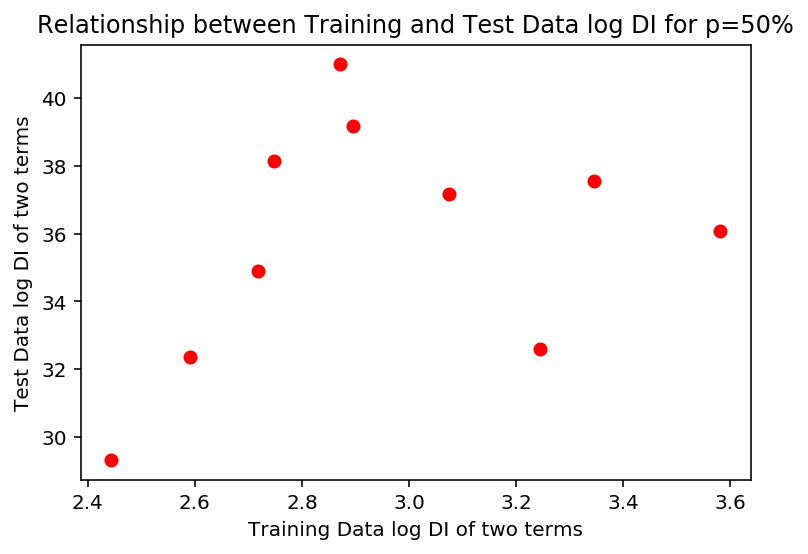

In [9]:
plt.plot(train_logs, test_logs, "ro")
plt.title("Relationship between Training and Test Data log DI for p=50%")
plt.xlabel("Training Data log DI of two terms")
plt.ylabel("Test Data log DI of two terms")